<a href="https://colab.research.google.com/github/lookmeebbear/OpenRS_MIST2024/blob/main/CNNforRS_Classification_Lookmee_MIST2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Land use Land cover level 1 classification by UNET model in Nonthaburi**

Thepchai Srinoi

Department of Survey Engineering

Chulalongkorn University

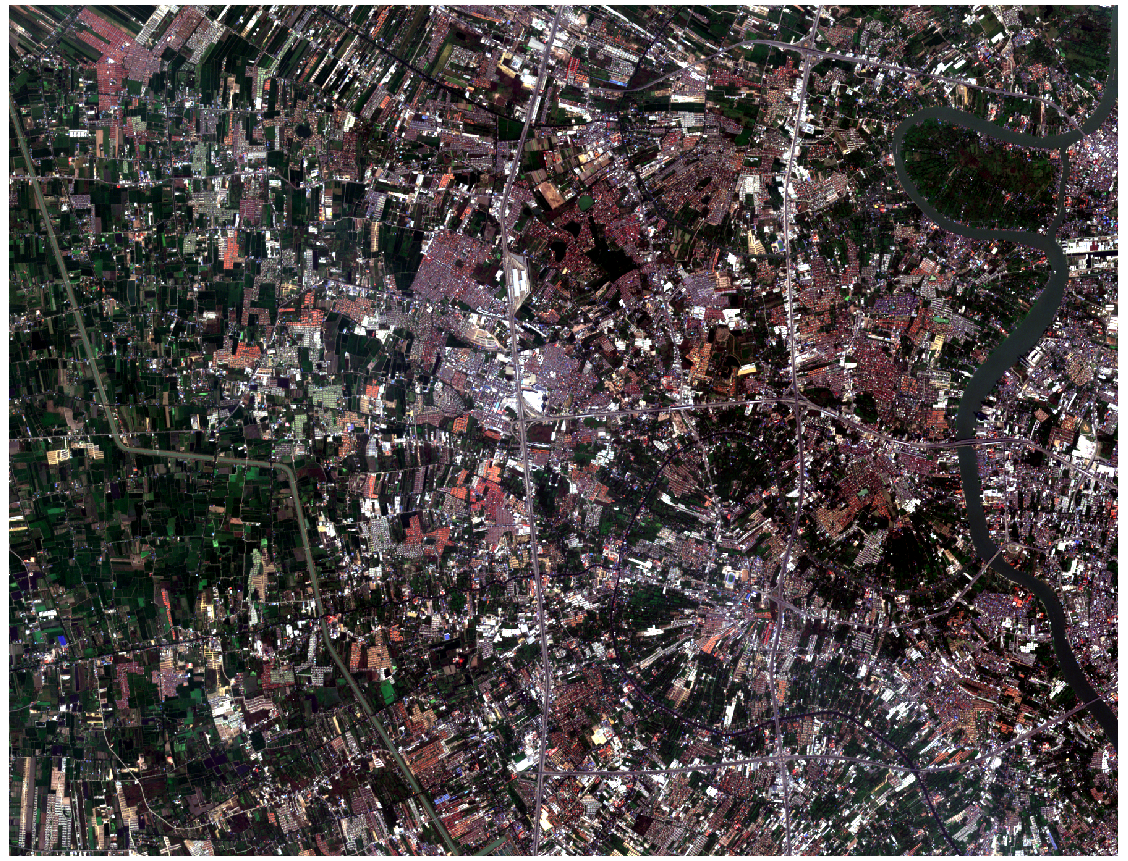

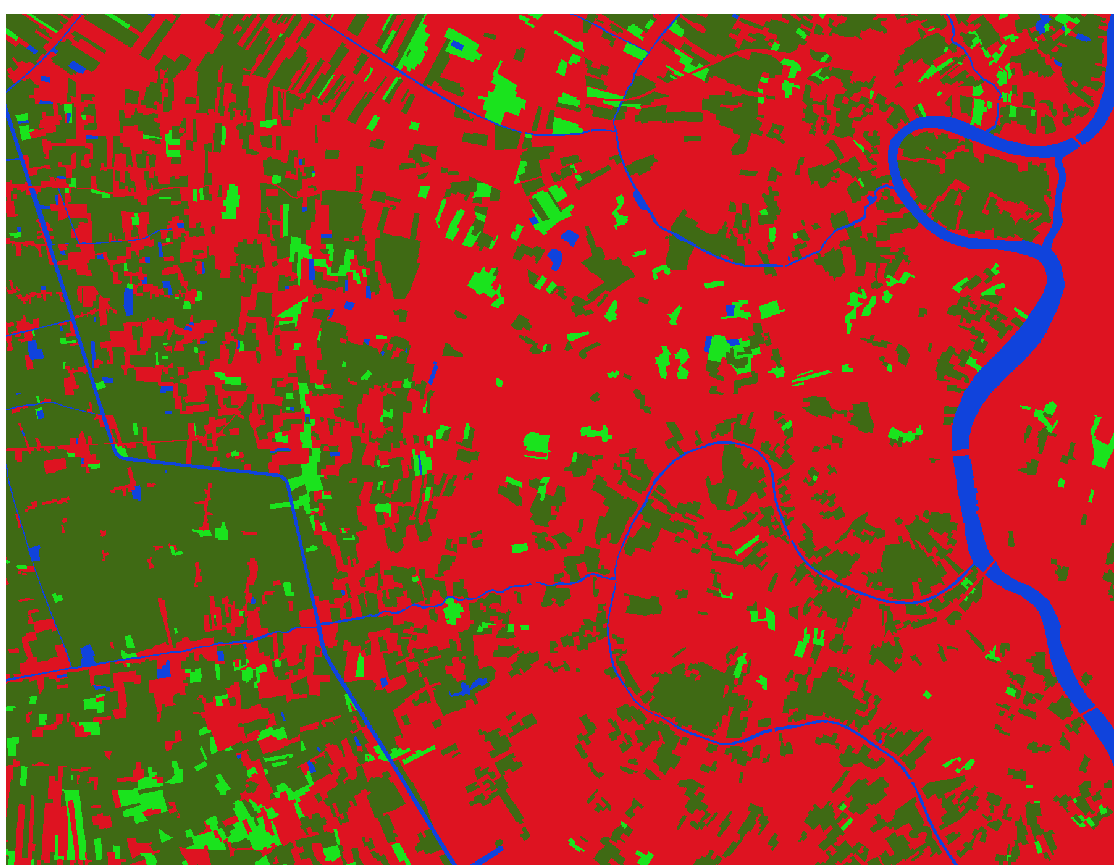

ลง library ที่จำเป็น ทั้งการเปิดภาพ แสดงผลสถาปัตยกรรม การทำแบบจำลองแยกส่วน

In [ ]:
!pip install rasterio visualkeras segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.8 MB/s eta 0:00:00


นำเข้าเครื่องมือที่จำเป็น

In [ ]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist
import visualkeras

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

ดาวน์โหลดข้อมูลทำแบบจำลอง

In [ ]:
# https://drive.google.com/file/d/1ld7y-7dHSWDbefL5cc06VnukbZ29bdY7/view?usp=drive_link
!gdown https://drive.google.com/uc?id=1ld7y-7dHSWDbefL5cc06VnukbZ29bdY7

Downloading...
From (original): https://drive.google.com/uc?id=1ld7y-7dHSWDbefL5cc06VnukbZ29bdY7
From (redirected): https://drive.google.com/uc?id=1ld7y-7dHSWDbefL5cc06VnukbZ29bdY7&confirm=t&uuid=fa21ad57-382c-44ae-ab87-4379561807a3
To: /content/Lookmee_Nont_L1_CNN.zip
100% 35.2M/35.2M [00:01<00:00, 26.2MB/s]


แตกไฟล์

In [ ]:
!unzip Lookmee_Nont_L1_CNN.zip

Archive:  Lookmee_Nont_L1_CNN.zip
  inflating: patch_nonthaburi_classL1/patchclass_1.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_10.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_100.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_101.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_102.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_103.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_104.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_105.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_106.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_107.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_108.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_109.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_11.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_110.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_111.tiff  
  inflating: patch_nonthaburi_classL1/patchclass_112.tiff  
  inflatin

ลองนับจำนวนข้อมูล

In [ ]:
import os
import fnmatch

dir_path = '/content/patch_nonthaburi_classL1/'
count = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
print('File Count:', count)

File Count: 540


นำภาพเข้าชุดอาร์เรย์ของข้อมูล input

In [ ]:
XImages = np.zeros([count, 64, 64, 10], dtype="float32")

dir = '/content/patch_nonthaburi_optical'
for j in range(1,count+1) :
  with rasterio.open( dir + '/patchoptical_' + str(j) + '.tiff') as img:
    tmp = np.moveaxis(img.read(), 0, 2)
    XImages[j-1] = tmp[:,:,:]


นำภาพเข้าชุดอาร์เรย์ของข้อมูล output

In [ ]:
YImages = np.zeros([count, 64, 64, 1], dtype="uint8")

dir = '/content/patch_nonthaburi_classL1'
for j in range(1,count+1) :
  with rasterio.open( dir + '/patchclass_' + str(j) + '.tiff') as img:
    tmp = np.moveaxis(img.read(), 0, 2)
    YImages[j-1] = tmp[:,:,:]


สุ่มเปิดภาพดาวเทียม และ ภาพ label



LU_CODE = ['A','M','U','W']

A - พื้นที่เกษตร

M - พื้นที่เบ็ดเตล็ด ... ทุ่งหญ้า ที่ลุ่ม ที่ทิ้งขยะ บ่อขุด ...

U - พื้นที่ชุมชนและสิ่งปลูกสร้าง

W - แหล่งน้ำ

In [ ]:
from matplotlib import colors
levels = [0,  1,  2,  3,  4]

clrs = ["darkgreen", "springgreen", "red"  , "blue"]

cmap, norm = colors.from_levels_and_colors(levels, clrs)
len(clrs)

4

240


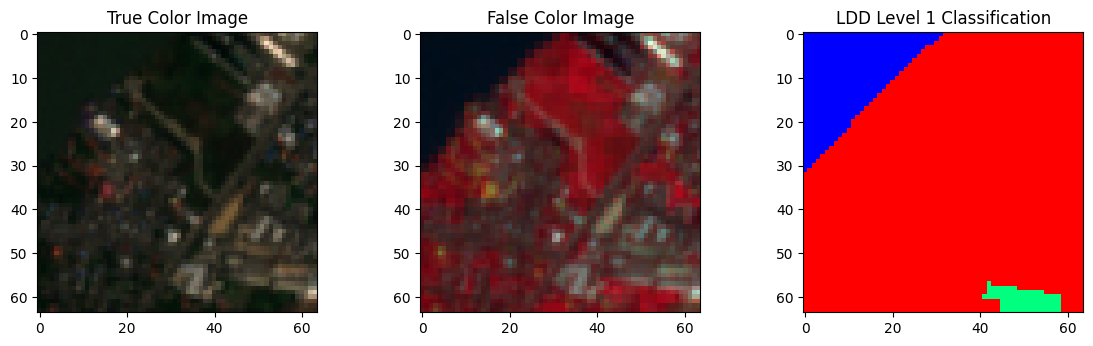

In [ ]:
import random
import matplotlib.pyplot as plt

from rasterio.plot import show, adjust_band

random_image_id = random.randint(0, count)
#random_image_id = 205
print(random_image_id )
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("True Color Image")
plt.imshow( adjust_band( XImages[random_image_id][:,:, [2,1,0] ] ) )

plt.subplot(232)
plt.title("False Color Image")
plt.imshow( adjust_band( XImages[random_image_id][:,:, [5,2,1] ] ) )

plt.subplot(233)
plt.title("LDD Level 1 Classification")
plt.imshow(YImages[random_image_id] , cmap = cmap, vmin=1, vmax=4)

ไล่ code แทนชื่อ LULC1

In [ ]:
print( np.unique(YImages) )
total_classes = len( np.unique(YImages) )
print( total_classes )

[1 2 3 4]
4


แปลงจาก 0 1 2 3 ... 11 เป็นรูปแบบที่เหมาะสม เช่น

แปลงจาก 2 เป็น [1 0 0 0 ... 0]

In [ ]:
label = keras.utils.to_categorical(YImages,num_classes=5 )

แบ่ง train/test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XImages, label , train_size = 0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(270, 64, 64, 10)
(270, 64, 64, 10)
(270, 64, 64, 5)
(270, 64, 64, 5)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

64
64
10
5


ลง เครื่องมือ ที่เกี่ยวข้องกับการสร้าง สถาปัตยกรรมของแบบจำลอง

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

loss function สำหรับ image segmentation

In [ ]:
import keras
#from keras.utils import generic_utils
os.environ['SM_FRAMEWORK'] = "tf.keras" # ห้ามลืมสิ่งนี้
import segmentation_models as sm

weights = [0.2, 0.2, 0.2, 0.2, 0.2]

#Creating a criterion to measure Dice loss class_weights – Array (np.array) of class weights (len(weights) = num_classes).
#for details check: https://github.com/qubvel/segmentation_models


dice_loss=sm.losses.DiceLoss(class_weights = weights)
focal=sm.losses.CategoricalFocalLoss()
total=dice_loss+(1*focal)

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

สร้าง สถาปัตยกรรมนิวรอนเส็งเคร็ง UNET ขึ้นมา

In [ ]:
def multi_unet_model(n_classes=5, image_height=64, image_width=64, image_channels=10):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  #model.summary()
  return model

ใช้งาน

In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)
model = get_deep_learning_model()

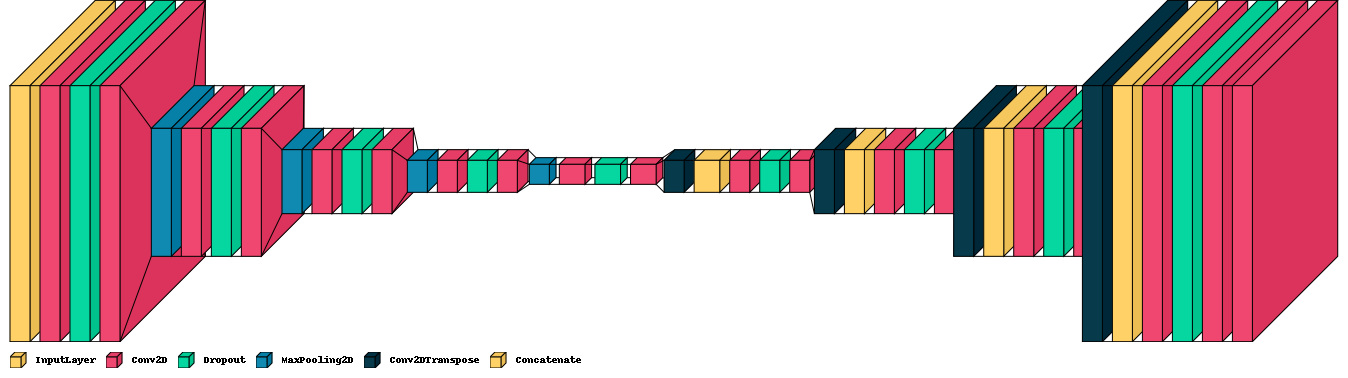

In [ ]:
visualkeras.layered_view(model, legend=True )

Solo ...

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = 'test.h5',
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jaccard_coef]

model.compile(optimizer='adam', loss=total, metrics=metrics)

history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose = 1,
                    epochs= 200,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks = callback_list)

Epoch 1/200
17/17 [==============================] - 8s 68ms/step - loss: 0.9895 - accuracy: 0.5297 - jaccard_coef: 0.2562 - val_loss: 0.9809 - val_accuracy: 0.5911 - val_jaccard_coef: 0.2605 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 1s 30ms/step - loss: 0.9768 - accuracy: 0.5918 - jaccard_coef: 0.3047 - val_loss: 0.9755 - val_accuracy: 0.5913 - val_jaccard_coef: 0.3132 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 1s 33ms/step - loss: 0.9688 - accuracy: 0.6802 - jaccard_coef: 0.3629 - val_loss: 0.9664 - val_accuracy: 0.6771 - val_jaccard_coef: 0.3768 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 1s 37ms/step - loss: 0.9593 - accuracy: 0.7558 - jaccard_coef: 0.4603 - val_loss: 0.9578 - val_accuracy: 0.7807 - val_jaccard_coef: 0.4811 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 1s 50ms/step - loss: 0.9555 - accuracy: 0.7805 - jaccard_coef: 0.4875 - val_loss: 0.9558 - val_accuracy: 0.7806 - val_jaccard_c

ดูผลลัผธ์

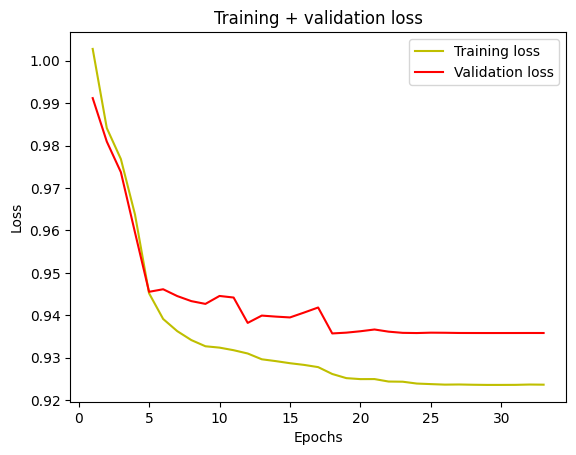

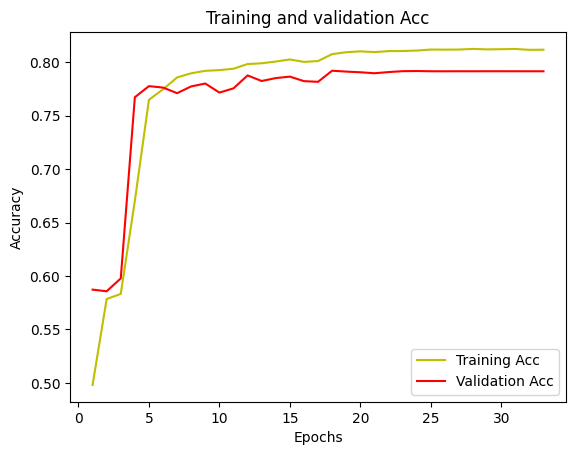

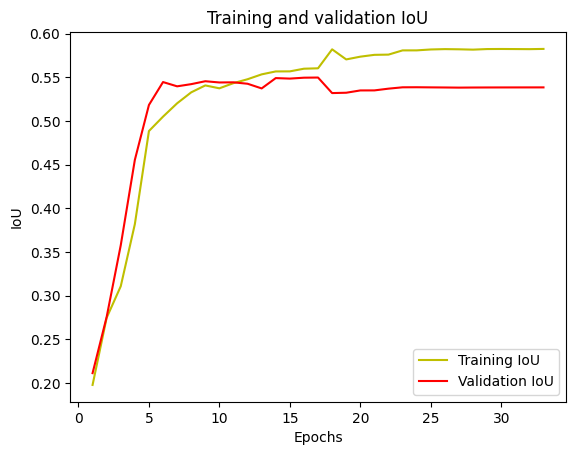

In [ ]:
from matplotlib import pyplot as plt
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training + validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = history.history['jaccard_coef']
val_iou = history.history['val_jaccard_coef']

plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

9/9 [==============================] - 1s 6ms/step


In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

238


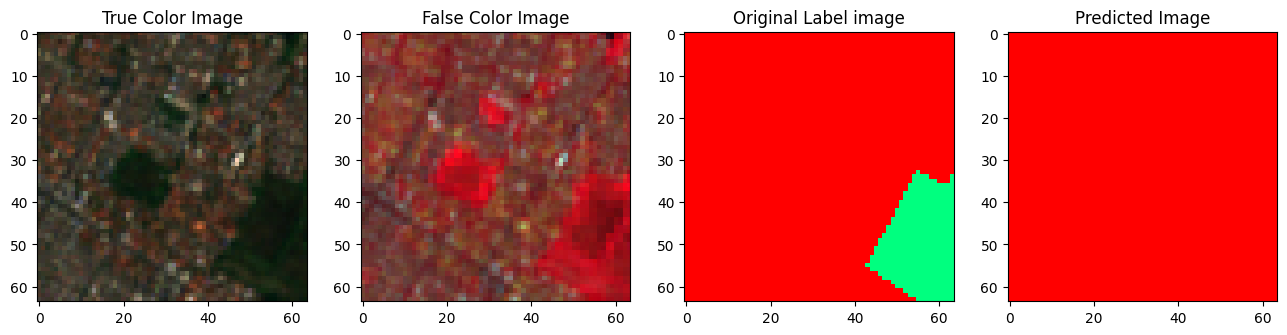

In [ ]:
test_image_number = random.randint(0, len(X_test) - 1)
#test_image_number = 163
predicted_image = y_pred_argmax[test_image_number]
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

print(test_image_number)

plt.figure(figsize=(16,16))

plt.subplot(141)
plt.title("True Color Image")
plt.imshow( adjust_band( test_image[:,:,[2,1,0] ] ) )

plt.subplot(142)
plt.title("False Color Image")
plt.imshow( adjust_band( test_image[:,:,[5,2,1] ] ) )

plt.subplot(143)
plt.title("Original Label image")
plt.imshow(ground_truth_image, cmap = cmap, vmin=1, vmax=4)

plt.subplot(144)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap = cmap, vmin=1, vmax=4)

อย่ามาสาย Deep Learning เลยครับ เครียดจัง